# CAB420, Metric Learning, Example 1: Siamese Networks
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will look at Siamese Networks. These are very useful when we have things that we want to compare. A classic example is a verification problem, where we want to tell if two things are the same. In our example, we're going to try and work out if two items of clothing are the same type of thing.

## Too Long; Didn't Read:
* Siamese networks are used to compare two things. They contain two identical branches, i.e. both branches have the exact same weights. This means that inputs passed through the networks have features extracted in a consistent manner
* To actually compare the two things, we need to define a way to compare two deep features. In this example we've used binary cross entropy and trained a simple classifier to tell if two things are the same or not. Effectivley, we've turned this into an image classification problem. We pass a pair of images in, and the network outputs a 1 or a 0 to indicate if the pair is the same or different.
* To train the network, we have to define the network in two parts, and then join them together. This takes a small amount of extra effort, but really not much
* Our network now takes paired data (i.e. image pairs). This means that we need to stuff about a bit more with data. What we've done here is the easiest option - just creating a bunch of pairs. This is ok, but not optimal. A better approach is to use generators, though this get's more complex (and is thus out of scope).
* While the approach works (for clothing), it is limited in that all it can do is say if two things are the same type of thing or not. For some applications this is enough. For others where we'd like to know how similar things are, this doesn't offer that information in any reliable sort of way

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# for consistency
random.seed(4)

## The Data
We're going to use fashion MNIST again, but we need to handle it a bit differently. We need paired data for this task, so we need to use fashion MNIST to create pairs where the pair is either of the same type, or a different type.

We'll start by loading our data, same as always.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

Here's where our data situation get's a bit more interesting. We need paired data. To do this we'll just create a function that takes the data in, and generates a bunch of pairs with a label to say if the pair is the same or different. Then, we can pass our fashion MNIST data into this function, create some huge number of pairs, and use this to train our model. For our function, we'll make sure that we generate a balanced data set, i.e. the number of "same pairs" will be equal to the number of "different pairs".

It's important to note that this approach is sub-optimal. The pairs we generate will be a fraction of the true number of possible pairs, and they'll sit in memory taking up a bunch of space. This isn't a big problem for our task here, but for more complex problems we'd like a better solution. Approaches that dynamically create pairs are a much better option - but these also a bunch of extra complexity to the pre-processing, which is why we've skipped them here. There are multiple ways to handle the dynamic pair creation (you can use generators at the input of the network, or fancy loss formulations depending on the exact approach), but such approaches are outside the scope of this example. If you're interested in this, have a look at the bonus examples.

In [3]:
def GetSiameseData(imgs, labels, num_pairs):

    image_a = numpy.zeros((num_pairs, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((num_pairs, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(num_pairs);
    
    for i in range(num_pairs):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

We'll quickly test the function  to make sure it's not doing something stupid. As always, visualise early, visualise often.

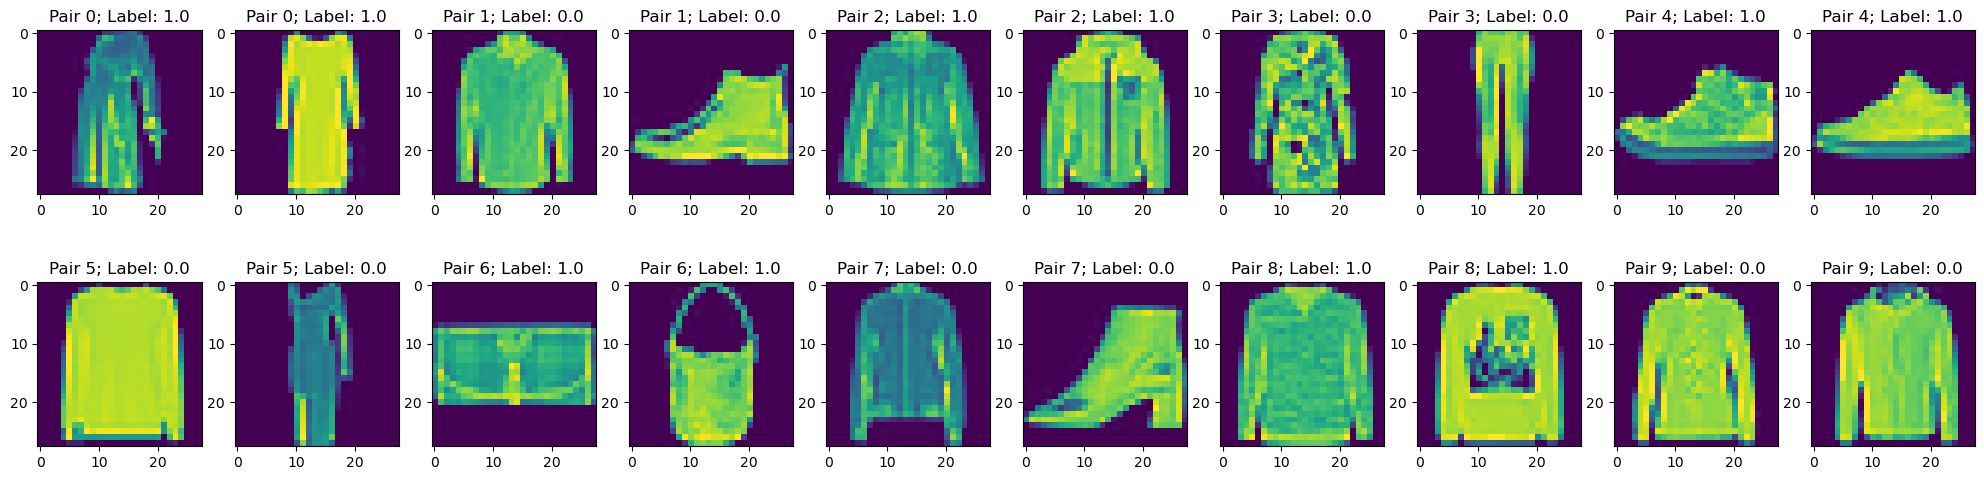

In [4]:
x, y = GetSiameseData(x_train, y_train, 10)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))    

We can see above what our data for the network looks like. We get pairs of images. Pairs that are labelled `1` have images of the same type (i.e. both images will be shoes, or bags), while pairs labelled `0` have images of different things.

## The Network

So what does this thing look like? The broad idea is this:
* We have a standard network, but rather than end in an output of some sort, it will learn a dense feature. We term this an embedding. As such our final layer is a dense layer of some arbitrary length.
* We will get an embedding for two images, each embedding will be obtained from the same network, so will be based on the same weights. The idea is that if we pass two of the same image through, we'll get the same embedding for both. Hopefully if we pass two similar images through, we'll get two similar embeddings.
* To compare these two embeddings, we'll train a simple classifier, i.e. a single layer with a binary cross entropy loss, that will tell us if the embeddings (and thus images) are from the same thing.

Embedding size is a fairly key parameter in all of this. For now, we'll leave that fixed at $32$, but this is a good parameter to play around with.

### Building the Network

The first thing we need to do is setup our network. We'll create a simple VGG like network as our Siamese branch. We'll use our vgg functions for that, borrowed from earlier examples.

Note that you could just as easily replace this with a ResNet, or a pre-trained network from elsewhere.

In [5]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

We'll now create the common branch. This is the bit that we pass both the inputs through. Basically we just:
* Create an input
* Create the network with our desired parameters
* Add an embedding layer
* Turn that into a model

In [6]:
embedding_size = 32
dummy_input = keras.Input((28, 28, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')
base_network.summary()

Model: "SiameseBranch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)         │        584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 28, 28, 8)         │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation (Activation)         │ (None, 28, 28, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d               │ (None, 28, 28, 8)         │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 14, 14, 16)        │         64 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 16)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_1             │ (None, 14, 14, 16)        │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)          │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 7, 7, 32)          │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_2             │ (None, 7, 7, 32)          │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 1568)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 256)               │    401,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_3           │ (None, 256)               │      1,024 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼──────────

 Total params: 429,176 (1.64 MB)

 Trainable params: 428,552 (1.63 MB)

 Non-trainable params: 624 (2.44 KB)

At this point, we can treat `base_network` like it's layer. As such we'll
* create our two actual inputs
* pass each of those through the base_network

In [7]:
input_a = keras.Input((28, 28, 1), name='InputA')
input_b = keras.Input((28, 28, 1), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

Now we can combine those two embeddings, and throw in a couple of dense layers to do our classification. After that, it's the usual deal of building the model, specifing the inputs and outputs, and then onto training.

In [8]:
combined = layers.concatenate([embedding_a, embedding_b])
combined = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

siamese_network = keras.Model([input_a, input_b], output, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ InputA (InputLayer) │ (None, 28, 28, 1) │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ InputB (InputLayer) │ (None, 28, 28, 1) │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ SiameseBranch       │ (None, 32)        │ 429,176 │ InputA[0][0],        │
│ (Functional)        │                   │         │ InputB[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 64)        │       0 │ SiameseBranch[0][0], │
│ (Concatenate)       │                   │         │ SiameseBranch[1][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │   8,320 │ concatenate[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │     129 │ dense_2[0][0]        │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 437,625 (1.67 MB)

 Trainable params: 437,001 (1.67 MB)

 Non-trainable params: 624 (2.44 KB)

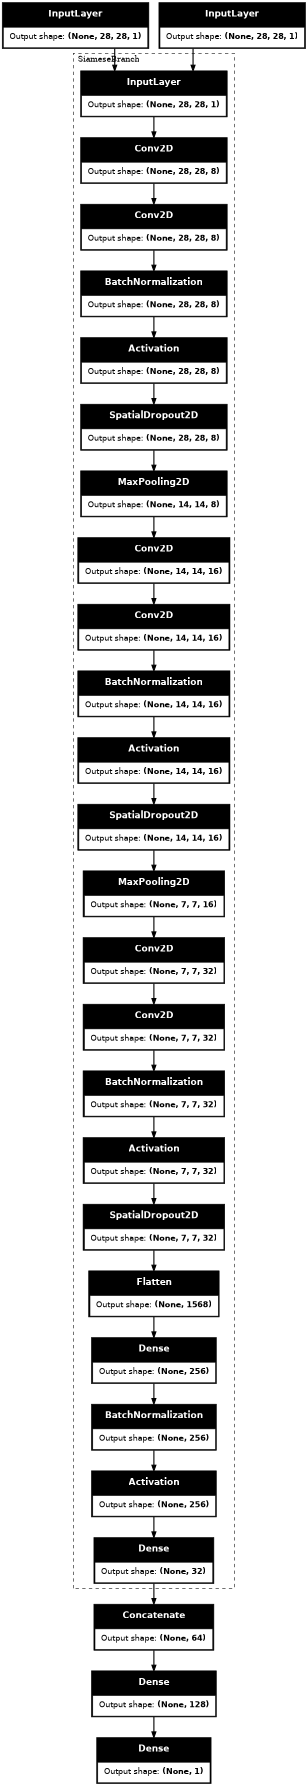

In [9]:
keras.utils.plot_model(siamese_network, show_shapes=True, dpi=40, expand_nested=True)

The above image gives a good sense of what the model looks like. Note that the details of `SiameseBranch` are shown via setting `expand_nested=True`. Both inputs are going into the same network, and we're then going to the outputs and pass these through a couple of other layers to make our classification descision.

In terms of compiling the model, we'll use a binary cross entropy loss (as our output can be 0 or 1), and Adam.

In [10]:
siamese_network.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'], 
                        jit_compile=False)

Now for our training, we'll start by creating our paired data. As noted above, creating a fixed set of pairs like this is not best practice, but it keeps things simple - hence we'll take this approach. 

We'll create $60,000$ pairs for training, and $10,000$ for testing.

In [11]:
siamese_train_x, siamese_train_y = GetSiameseData(x_train, y_train, 60000)
siamese_test_x, siamese_test_y = GetSiameseData(x_test, y_test, 10000)

siamese_network.fit(siamese_train_x, siamese_train_y, batch_size = 128, epochs=10, validation_data = (siamese_test_x, siamese_test_y))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.7455 - loss: 0.4778 - val_accuracy: 0.8882 - val_loss: 0.2752
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8855 - loss: 0.2704 - val_accuracy: 0.9080 - val_loss: 0.2312
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9055 - loss: 0.2266 - val_accuracy: 0.9138 - val_loss: 0.2196
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9143 - loss: 0.2048 - val_accuracy: 0.9196 - val_loss: 0.1956
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9205 - loss: 0.1907 - val_accuracy: 0.9208 - val_loss: 0.1919
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9249 - loss: 0.1833 - val_accuracy: 0.9205 - val_loss: 0.1938
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9285 - loss: 0.1708 - val_accuracy: 0.9104 - val_loss: 0.2317
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9302 - loss: 0.1688 - val_accuracy: 

# The Results
Let's have a look at some outputs.

We'll start with just a random 10 samples and see what it returns. For extra info, we'll plot the raw score out of the network rather than the rounded result, and show the expected score as well.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


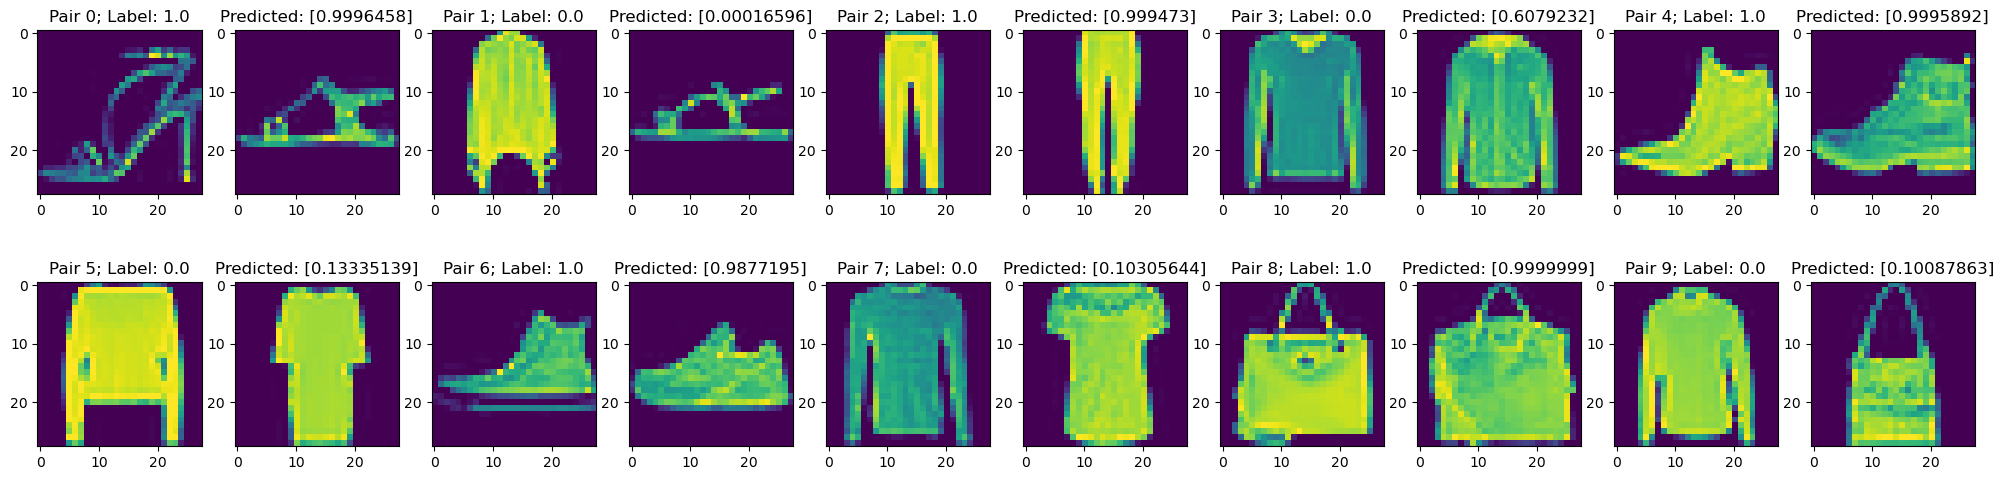

In [12]:
x, y = GetSiameseData(x_test, y_test, 10)
res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))
    

Generally it's done OK, and about as well as we'd expect given the ~90% validation accuracy.

Let's try a slightly different experiment now. Let's compare 10 pairs again, but this time we'll make the first image in each pair the same. Ideally, we'd like to see similar types of clothing getting scores closer to 1. So for example, if we comapre a t-shirt and a jumper, and the same t-shirt with a shoe, we'd like to see a higher similarity with the jumper (becuase most t-shirts are more like jumpers than shoes).

We won't try to show ground truth labels here, and we'll just rely on our eyes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


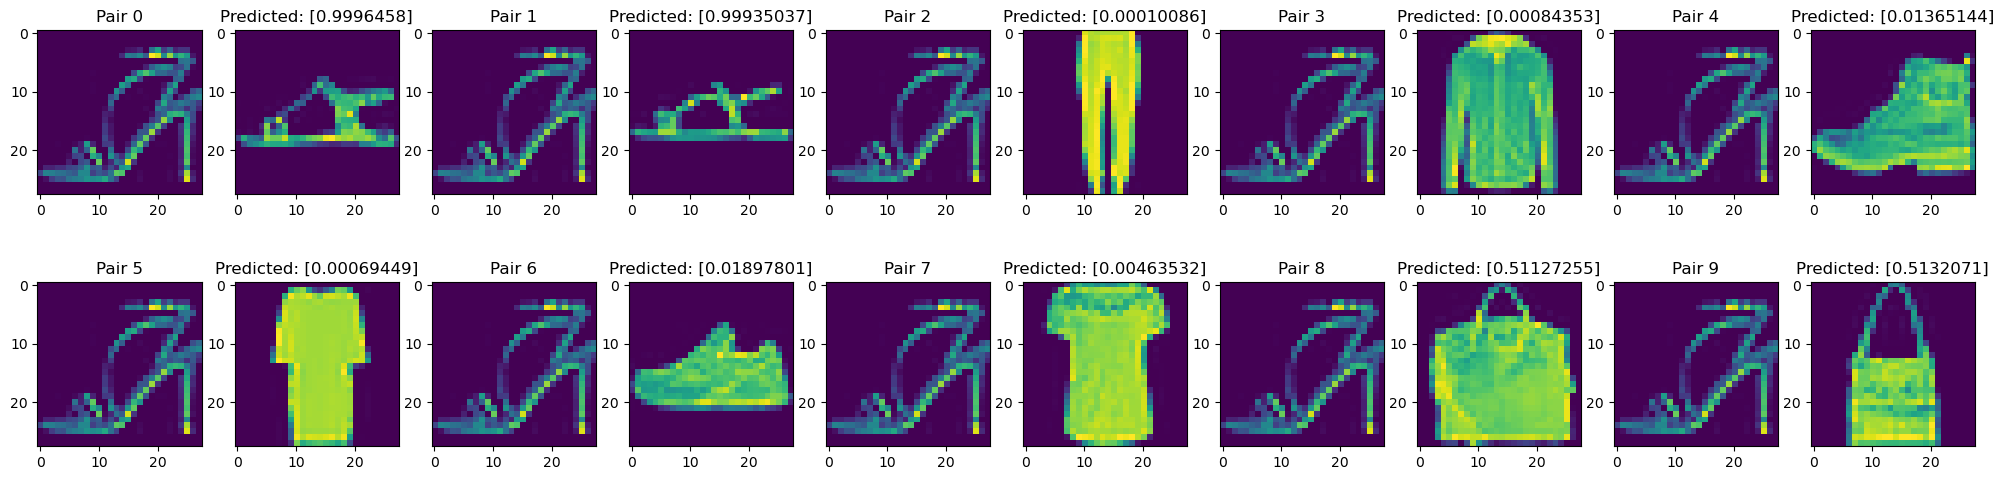

In [13]:
for i in range(10):
    x[0][i,:] = x[0][0,:]

res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))

This again seems ok. Where it get's murky is when looking at the intermediate values. It seems to do quite well at getting things that are very different separate (shirts and shoes), and it's pretty good when things are of the same class. Ultimatley, our network has good sense of when things are the same and when they are different, but it doesn't really understand the idea of similarity.

### Visualising the Embedding Space

Let's try to unpack this some more. We'll visualise the embeddings we're getting out of the network. These embeddings are 32 dimensional, which is hard to plot, so we'll use t-SNE to obtain a 2D representation.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


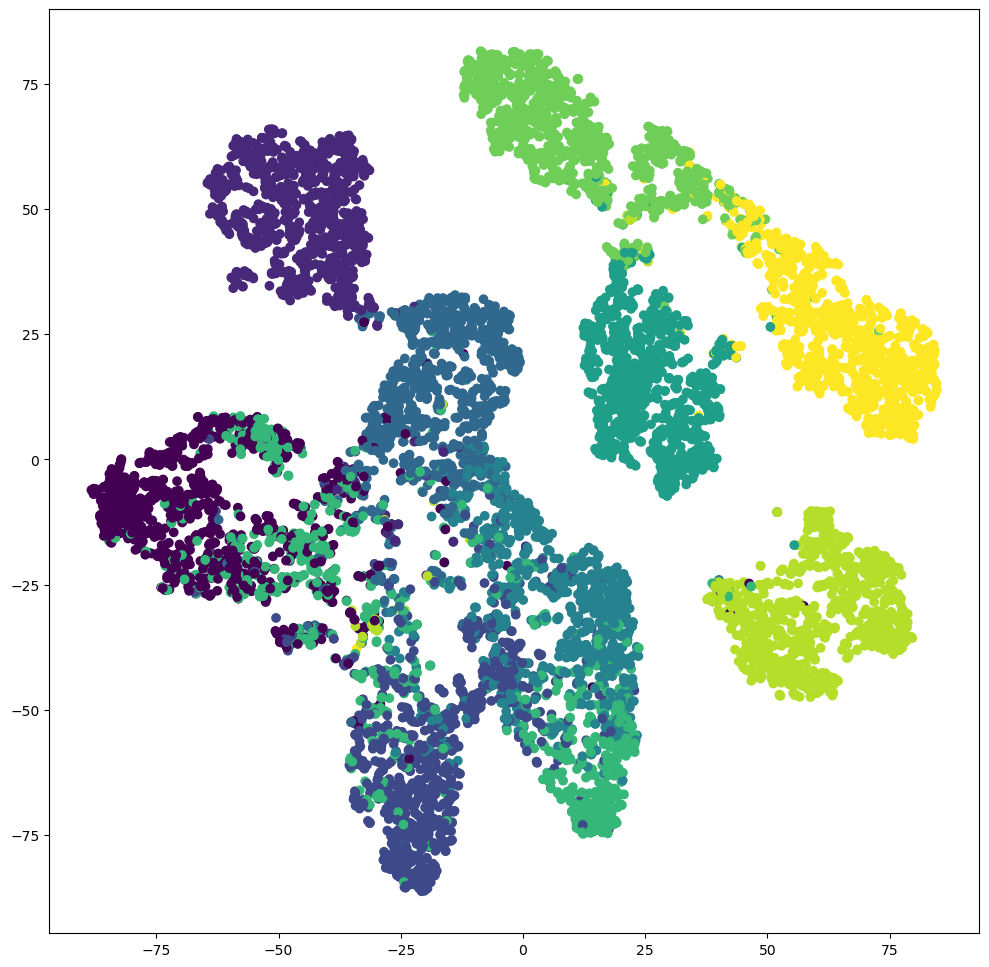

In [14]:
embeddings = base_network.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

Does this look good?

It's not bad, and we can certainly see that some classes are well separated. Others, not so much. On the whole, this has worked ok. That said, it does raise an important issue, is the output of this network of use for anything more than saying if two things are the same? Can it tell us how similar two things are? It can't really, and that's a weakness with this approach.

### How does this compare to a regular CNN?

Good question. Let's find out.

We'll use a VGG like network. In fact, we'll take the backbone that we setup earlier and just attach a classification layer to that.

In [15]:
dummy_input = keras.Input((28, 28, 1))
vgg_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(vgg_network)
output_layer = layers.Dense(10, activation=None, name='feature_extractor')(embedding_layer)
vgg_network = keras.Model(dummy_input, output_layer, name='SimpleVGGNetwork')

vgg_network.summary()

Model: "SimpleVGGNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 8)         │        584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_4           │ (None, 28, 28, 8)         │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_4 (Activation)       │ (None, 28, 28, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_3             │ (None, 28, 28, 8)         │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_5           │ (None, 14, 14, 16)        │         64 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_5 (Activation)       │ (None, 14, 14, 16)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_4             │ (None, 14, 14, 16)        │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 32)          │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_6           │ (None, 7, 7, 32)          │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_6 (Activation)       │ (None, 7, 7, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_5             │ (None, 7, 7, 32)          │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 256)               │    401,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_7           │ (None, 256)               │      1,024 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼──────────

 Total params: 429,506 (1.64 MB)

 Trainable params: 428,882 (1.64 MB)

 Non-trainable params: 624 (2.44 KB)

In [16]:
vgg_network.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'], jit_compile=False)
history = vgg_network.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7163 - loss: 0.7832 - val_accuracy: 0.8446 - val_loss: 0.4444
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8563 - loss: 0.3874 - val_accuracy: 0.8345 - val_loss: 0.4493
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8699 - loss: 0.3475 - val_accuracy: 0.8544 - val_loss: 0.3998
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8798 - loss: 0.3153 - val_accuracy: 0.8790 - val_loss: 0.3398
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8898 - loss: 0.3007 - val_accuracy: 0.8380 - val_loss: 0.4616
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8921 - loss: 0.2908 - val_accuracy: 0.8825 - val_loss: 0.3411
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8968 - loss: 0.2792 - val_accuracy: 0.8737 - val_loss: 0.3400
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8971 - loss: 0.2723 - val_accuracy: 0

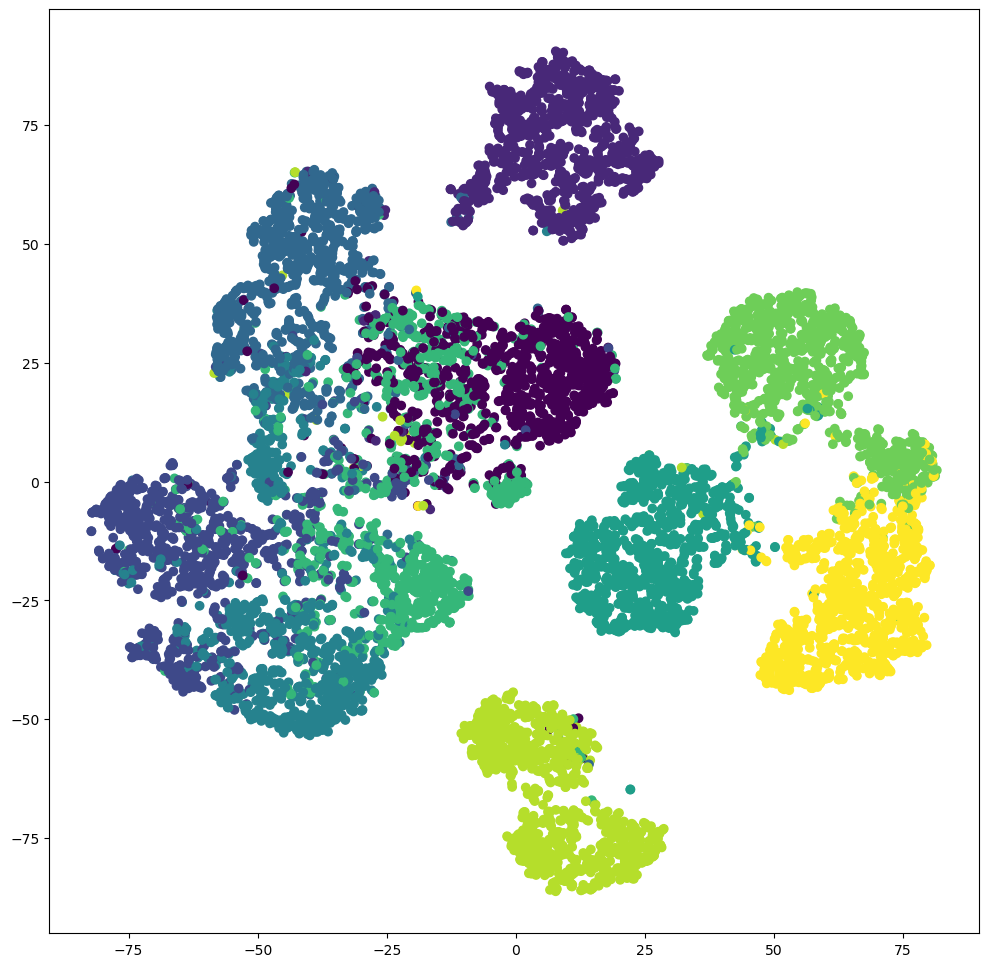

In [17]:
intermediate_layer_model = keras.Model(inputs=vgg_network.input,
                                       outputs=vgg_network.get_layer('feature_extractor').output)
embeddings = intermediate_layer_model.predict(x_test, verbose=False)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

It's tricky to compare this to what we had with the Siamese network, but one the whole I'd say that our conventionally trained classifier is a little worse. Some classes are very well separated, as they were for the Siamese network, but there's (to my eyes) more confusion between some of the classes.

Keep in mind however that this is visulaising 32 dimensional information in 2D, so we're not seeing everything. One the whole, the two are actually pretty similar.

## Final Thoughts
In this example we've seen how to train a Siamese network. Our network consists of:
* Two identical branches, that basically act as feature extractors. The idea of these is simply to get a compact representation of the image that (hopefully) describes what that thing is
* A smaller subnetwork that compares the two features

We can vary the complexity of both these components, and even vary the way that we combine the features. We could, for example, subtract the two vectors rather than concatenating them if we wish.

The actual mechanics of making this happen is pretty straight forward. We simply create our common branch and pass both inputs through that, and let the API work out how it all ties together. When we train the network, we just need to be passing it pairs of images as we now have two inputs, otherwise it's very like what we've already been doing.

Finally, we've seen that while this works, it perhaps isn't the best method for the reason that our final output is not overly meaningful. It tells us if two things are the same class or not, and nothing more. There is no information on ranking or similarity, which has implications for other tasks where we want to know how similar two things are. Often with these sort of networks, they are used in retrieval tasks, i.e. given some input, return the $N$ most similar entries from a database. For that to work, we need to be able to rank things. 

The limitations of our network are also hinted at by the embeddings plot, which suggests that not all classes can be separated so easily.